In [82]:
import os
import tensorflow as tf
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
import numpy as np
import random
from sklearn import preprocessing
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import time
from datetime import datetime
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.utils import to_categorical


In [84]:
#Variables
run = datetime.fromtimestamp(time.time()).strftime("%Y.%m.%d-%H%M")
optimizer = 'SGD'
scale = 255
batch_size = 32
epochs = 16
augumentation = 'No'
regularizer = None
data = 'Updated'
grayscale = 'Yes'

In [85]:
if data == 'Original':

    training_dir = '../data/training'
    val_dir = '../data/validation'
    testing_dir = '../data/testing'

else:

    training_dir = '../data/updated_training'
    val_dir = '../data/updated_validation'
    testing_dir = '../data/updated_testing'

In [86]:
# Set up paths and labels
severity_levels = ['01-minor', '02-moderate', '03-severe']  # Labels by order

# Initialize lists for images and labels
images = []
labels = []
labels_values = []

# Load images and labels in a single loop
for values, level in enumerate(severity_levels):
    for image_path in glob.glob(os.path.join(training_dir, level, '*')):
        img = cv2.imread(image_path)  # Read image
        img_resized = cv2.resize(img, (scale, scale))  # Resize image
        
        if grayscale == 'Yes':
            img_gray_scale = cv2.cvtColor(cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY),cv2.COLOR_BGR2RGB)
            images.append(img_gray_scale)  # Append gray image
        else:
            images.append(img_resized)  # Append resized image

        labels.append(level)
        labels_values.append(values)

    for image_path in glob.glob(os.path.join(testing_dir, level, '*')):
        img = cv2.imread(image_path)  # Read image
        img_resized = cv2.resize(img, (scale, scale))  # Resize image
        if grayscale == 'Yes':
            img_gray_scale = cv2.cvtColor(cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY),cv2.COLOR_BGR2RGB)
            images.append(img_gray_scale)  # Append gray image
        else:
            images.append(img_resized)  # Append resized image
        labels.append(level)
        labels_values.append(values)

    for image_path in glob.glob(os.path.join(val_dir, level, '*')):
        img = cv2.imread(image_path)  # Read image
        img_resized = cv2.resize(img, (scale, scale))  # Resize image
        if grayscale == 'Yes':
            img_gray_scale = cv2.cvtColor(cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY),cv2.COLOR_BGR2RGB)
            images.append(img_gray_scale)  # Append gray image
        else:
            images.append(img_resized)  # Append resized image
        labels.append(level)
        labels_values.append(values)

Severity Level:  03-severe
Severity Level Value:  2


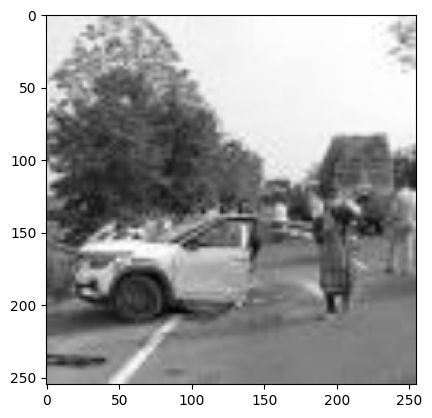

In [87]:
sample_number = 2400
plt.imshow(images[sample_number])
print(f'Severity Level: ',labels[sample_number])
print(f'Severity Level Value: ',labels_values[sample_number])

In [88]:
# Convert lists to numpy arrays
images = np.asarray(images, dtype='float32')
labels = np.array(labels)
labels_values = np.asarray(labels_values, dtype='int32')

In [89]:
print(images.shape)
print(labels_values.shape)

(2430, 255, 255, 3)
(2430,)


In [90]:
data = images.flatten().reshape(images.shape[0],(images.shape[1]*images.shape[2]*images.shape[3]))

In [91]:
# mean = 0 ; standard deviation = 1.0
scaler = preprocessing.StandardScaler()
s_data = scaler.fit_transform(data)

# print(scaler.mean_)
# print(scaler.scale_)
s_data.shape
#s_train_data.shape.mean(axis=0)
#s_train_data.shape.std(axis=0)

(2430, 195075)

In [92]:
labels_one_hot = to_categorical(labels_values, num_classes=3)

In [93]:
labels_one_hot.shape

(2430, 3)

In [94]:
# Using sklearn's train_test_split to split data
X_train, X_test, y_train, y_test = train_test_split(s_data, labels_one_hot , random_state=42, test_size=0.20)

In [95]:
input_dim = s_data.shape[1]
hidden_dim = 100
output_dim = labels_one_hot.shape[1]

model = Sequential()
model.add(Dense(hidden_dim, input_dim=input_dim, activation="relu", kernel_regularizer=l2(regularizer)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64, activation="relu", kernel_regularizer=l2(regularizer)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation="relu", kernel_regularizer=l2(regularizer)))
model.add(Dropout(0.2))
model.add(Dense(output_dim, activation="softmax", kernel_regularizer=l2(regularizer)))

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])

history = model.fit(X_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size)

/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/16
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.3239 - loss: 4.7021 - precision: 0.3310 - recall: 0.2327 - val_accuracy: 0.4513 - val_loss: 4.3152 - val_precision: 0.4302 - val_recall: 0.1897
Epoch 2/16
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.4049 - loss: 4.3964 - precision: 0.4329 - recall: 0.2635 - val_accuracy: 0.4051 - val_loss: 4.2198 - val_precision: 0.5312 - val_recall: 0.1744
Epoch 3/16
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.4289 - loss: 4.2770 - precision: 0.4420 - recall: 0.2590 - val_accuracy: 0.4205 - val_loss: 4.1294 - val_precision: 0.6250 - val_recall: 0.1538
Epoch 4/16
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.4307 - loss: 4.1620 - precision: 0.4725 - recall: 0.2535 - val_accuracy: 0.4205 - val_loss: 4.0480 - val_precision: 0.5750 - val_recall: 0.1179
Epoch 5/16
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.4719 - loss: 4.0321 - precision: 0.5364 - recall: 0.2764 - val_accuracy: 0.4513 - val_loss: 3.9748 

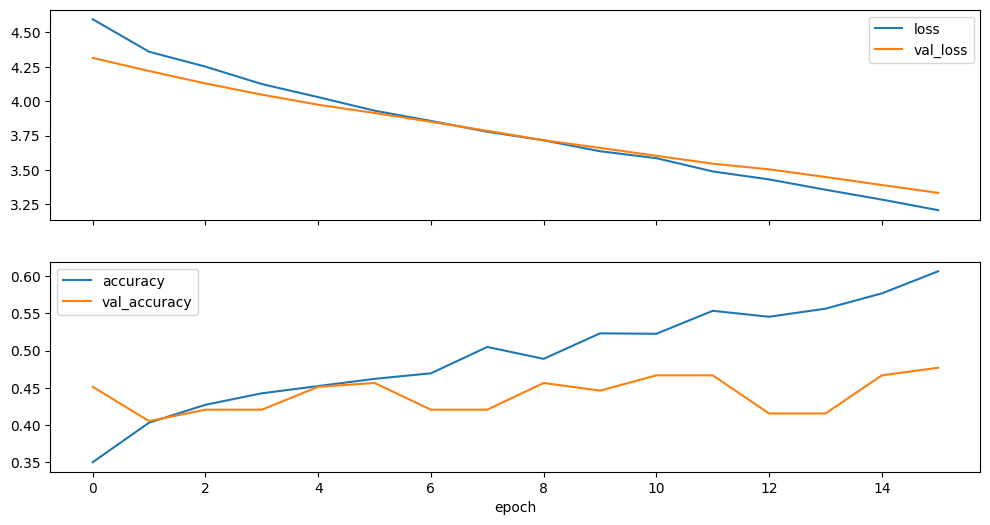

In [105]:
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df["epoch"] = history.epoch
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(12, 6))
history_df.plot(x="epoch", y=["loss", "val_loss"], ax=ax0)
history_df.plot(x="epoch", y=["accuracy", "val_accuracy"], ax=ax1);

In [97]:
y_train_pred = np.argmax(model.predict(X_train), axis=1)

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [98]:
y_train_labels = np.argmax(y_train, axis=1)

Training Confusion Matrix:


/var/folders/0g/5m9fzrnn1sz871_pvbsf70v40000gn/T/ipykernel_88866/7199672.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['minor', 'moderate', 'severe'], rotation=45)
/var/folders/0g/5m9fzrnn1sz871_pvbsf70v40000gn/T/ipykernel_88866/7199672.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ['minor', 'moderate', 'severe'])


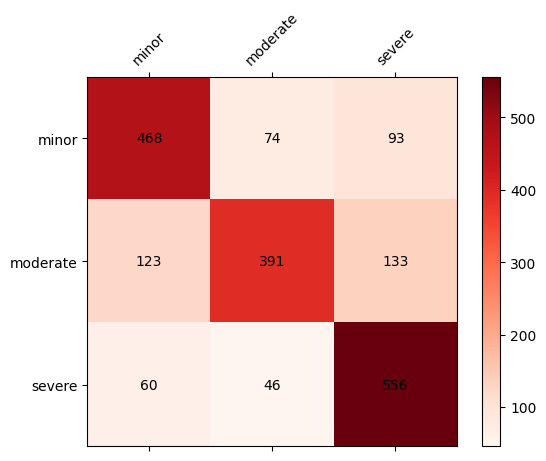

In [99]:
conf_matrix = confusion_matrix(y_train_labels, y_train_pred)
fig, ax = plt.subplots()
cax = ax.matshow(conf_matrix, cmap='Reds')

cbar = fig.colorbar(cax)

ax.set_xticklabels([''] + ['minor', 'moderate', 'severe'], rotation=45)
ax.set_yticklabels([''] + ['minor', 'moderate', 'severe'])

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(j, i, str(conf_matrix[i, j]), ha='center', va='center')
print('Training Confusion Matrix:')

plt.show()

In [100]:
# Print classification report
print(classification_report(y_train_labels, y_train_pred))

              precision    recall  f1-score   support

           0       0.72      0.74      0.73       635
           1       0.77      0.60      0.68       647
           2       0.71      0.84      0.77       662

    accuracy                           0.73      1944
   macro avg       0.73      0.73      0.72      1944
weighted avg       0.73      0.73      0.72      1944



In [101]:
y_pred = np.argmax(model.predict(X_test), axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [102]:
y_test_labels = np.argmax(y_test, axis=1)

In [103]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.55      0.54       175
           1       0.43      0.30      0.36       163
           2       0.42      0.53      0.47       148

    accuracy                           0.46       486
   macro avg       0.46      0.46      0.45       486
weighted avg       0.46      0.46      0.45       486



Testing Confusion Matrix:


/var/folders/0g/5m9fzrnn1sz871_pvbsf70v40000gn/T/ipykernel_88866/2064337500.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['minor', 'moderate', 'severe'], rotation=45)
/var/folders/0g/5m9fzrnn1sz871_pvbsf70v40000gn/T/ipykernel_88866/2064337500.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ['minor', 'moderate', 'severe'])


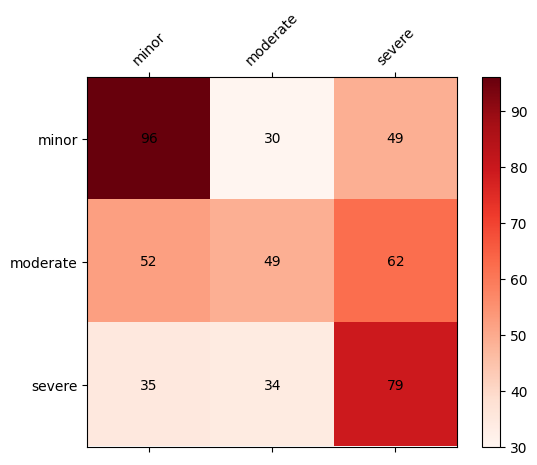

In [104]:
conf_matrix = confusion_matrix(y_test_labels, y_pred)
fig, ax = plt.subplots()
cax = ax.matshow(conf_matrix, cmap='Reds')

cbar = fig.colorbar(cax)

ax.set_xticklabels([''] + ['minor', 'moderate', 'severe'], rotation=45)
ax.set_yticklabels([''] + ['minor', 'moderate', 'severe'])

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(j, i, str(conf_matrix[i, j]), ha='center', va='center')
print('Testing Confusion Matrix:')

plt.show()